# Baseline

In [ ]:
# Enable interactive plot
%matplotlib notebook

import argparse 
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.animation as animation 
from IPython.display import HTML


#set animation update interval
updateInterval = 50

#set simulation parameters
nMajority = 1250
nMinority = 250
#fracHappy = 0.3
gridSize = 50
  
class Agent:
    def __init__(self, r=1, i=0, j=0):
       self.race = r
       self.goal = 0.4
       self.unhappy = False
       if (self.race==1):
           self.color = 0.5
       elif (self.race==2): 
           self.color = 1.0
       else:
           self.color = 0.0
       self.i = i
       self.j = j
           
def initAgents(a,nMajority,nMinority):
    for _ in range(nMajority):
        a.append(Agent(1))
    for _ in range(nMinority):
        a.append(Agent(2))
    return a

def placeAgents(agents,grid,gridSize,nMajority,nMinority):
    for _,agent in enumerate(agents):
        i = np.random.randint(1,gridSize+1,1)
        j = np.random.randint(1,gridSize+1,1)
        while (grid[i,j] != 0):
            i = np.random.randint(1,gridSize+1,1)
            j = np.random.randint(1,gridSize+1,1)
        agent.i = i
        agent.j = j
        grid[i,j] = agent.color
    return [agents,grid]

def checkHappy(agents,grid,nMajority,nMinority):
#def checkHappy(agents,grid,nMajority,nMinority,fracHappy):
    uha = []
    numberUnhappy = 0
    for _,agent in enumerate(agents):
        nSame = 0
        nDifferent = 0
        i = agent.i
        j = agent.j
        for m in range(int(i-1),int(i+2)):
            for n in range(int(j-1),int(j+2)):
                if (grid[m,n]==agent.color):
                    nSame=nSame+1
                elif(grid[m,n]!=0.0):
                    nDifferent = nDifferent+1
        nSame = nSame - 1
        if(nSame+nDifferent == 0):
            agent.unhappy = False
        elif(agent.goal >=(((nSame)/(nSame+nDifferent)))):
        #elif(fracHappy>=(((nSame)/(nSame+nDifferent)))):
            agent.unhappy = True
            numberUnhappy = numberUnhappy + 1
        else:
            agent.unhappy = False
    # print(numberUnhappy)
    return uha, numberUnhappy

def update(frameNum, img, grid, nMajority, nMinority, gridSize, agents): 
  
    # copy grid since we require 8 neighbors  
    # for calculation and we go line by line  
    newGrid = np.zeros([gridSize+2,gridSize+2]) 
    zeros = np.argwhere(grid[1:gridSize,1:gridSize]==0)
    for _,agent in enumerate(agents):
        if(agent.unhappy):
            o = np.random.randint(0,len(zeros))
            i = zeros[o][0]
            j = zeros[o][1]
            np.delete(zeros,o)
            grid[i,j] = agent.color
            agent.i = i
            agent.j = j
        newGrid[agent.i,agent.j] = agent.color
        
    # check for unhappy agents
    _,n = checkHappy(agents,newGrid,nMajority,nMinority)
    # update data 
    img.set_data(newGrid) 
    grid[:] = newGrid[:] 

    x.append(frameNum)
    y.append(n)
    line.set_data(x,y)
    return img, line,
  
#initialize grid
grid = np.zeros([gridSize+2,gridSize+2])

#instantiate agents
agents = []
agents = initAgents(agents,nMajority,nMinority)

#place agents
[agents,grid]= placeAgents(agents,grid,gridSize,nMajority,nMinority)
           
# set up animation 
x,y =[],[]
fig, (ax1,ax2) = plt.subplots(1,2) 
img = ax1.imshow(grid, interpolation='nearest') 
line, = ax2.plot([], [], lw=3)
ax2.set(xlim=(0,50), ylim=(0,200), aspect='0.25')
ani = animation.FuncAnimation(fig, update, fargs=(img, grid, nMajority, nMinority, gridSize, agents), 
                              frames = 50, 
                              interval=updateInterval, 
                              save_count=50) 

plt.show() 
HTML(ani.to_jshtml())


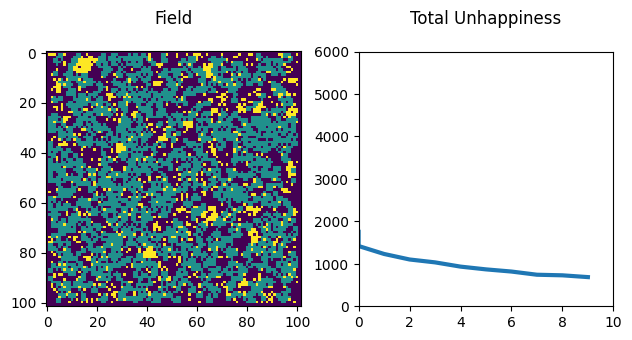

In [18]:
import numpy as np 
from math import floor
from collections import Counter
import matplotlib.pyplot as plt  
import matplotlib.animation as animation 
# Uncomment to display in .ipynb
from IPython.display import HTML


class Agent:
    def __init__(self, membership, numTeams, ufunc, i=0, j=0):
       self.team = membership
       self.ufunc = ufunc
       self.unhappy = False
       self.color = membership/numTeams
       self.i = i
       self.j = j


def initAgents(a,demographic):
    numTeams = len(demographic)
    for key,value in demographic.items():
        for _ in range(value['population']):
            a.append(Agent(key,numTeams,value['ufunc']))
    return a


def placeAgents(agents,grid,gridSize,):
    open = np.argwhere(grid[1:gridSize+1,1:gridSize+1]==0)
    for agent in agents:
        # select a random opening and move
        o = np.random.randint(0,len(open))
        i = open[o][0]+1    # index correction
        j = open[o][1]+1    # from argwhere shift
        agent.i = i
        agent.j = j
        grid[i,j] = agent.color
        # remove opening from list
        open = np.delete(open,o,0)
    return [agents,grid]


def checkHappy(agents,grid,nbrhd=3):
    uha = []
    numberUnhappy = 0
    dim = floor(nbrhd/2)
    for agent in agents:
        neighbors = []
        i = agent.i
        j = agent.j
        for m in range(int(i-dim),int(i+dim+1)):
            for n in range(int(j-dim),int(j+dim+1)):
                neighbors.append(grid[m,n])
        
        tally = Counter(neighbors)
        like = tally[agent.color]
        # correct for self counting
        like = like-1
        if(agent.ufunc(like)):
            agent.unhappy = False
        else:
            agent.unhappy = True
            numberUnhappy = numberUnhappy + 1
    return uha, numberUnhappy


def update(frameNum,grid,gridSize,agents,x,y,nbrhd=3,img=None,line=None):  
    # copy grid since we require 8 neighbors  
    # for calculation and we go line by line  
    newGrid = np.zeros([gridSize+2,gridSize+2]) 
    # find the list of open cells
    open = np.argwhere(grid[1:gridSize+1,1:gridSize+1]==0)
    for agent in agents:
        if(agent.unhappy):
            # select a random opening and move
            o = np.random.randint(0,len(open))
            i = open[o][0]+1    # index correction
            j = open[o][1]+1    # from argwhere shift
            agent.i = i
            agent.j = j
            # delete the opening from list
            open = np.delete(open,o,0)
        newGrid[agent.i,agent.j] = agent.color
        
    # check for unhappy agents
    _,n = checkHappy(agents,newGrid,nbrhd)
    # update data 
    if img: img.set_data(newGrid) 
    grid[:] = newGrid[:] 

    x.append(frameNum)
    y.append(n)
    if line: line.set_data(x,y)
    return img, x, y, line


#run trials without animations
def run_experiment(demographic=None,gridSize=100,nbrhd=3,frames=50,reps=10,filename='test'):
    demographics = demographic or {
        1:{'population':5000,'tolerance':0.3},
        2:{'population':1000,'tolerance':0.3}}
    big_Y = np.array(range(frames), ndmin=2)
    for r in range(reps):
        #initialize grid
        grid = np.zeros([gridSize+2,gridSize+2])

        #instantiate agents
        agents = []
        agents = initAgents(agents,demographics)

        #place agents
        [agents,grid]= placeAgents(agents,grid,gridSize)
        #data collection
        x,y =[],[]
        for f in range(frames):
            _,x,y,_ = update(f,grid,gridSize,agents,x,y,nbrhd)
        big_Y = np.concatenate((big_Y,np.array(y,ndmin=2)),axis=0)
    np.savetxt('outputs/{}.csv'.format(filename), 
           big_Y.T,
           delimiter =', ', 
           fmt ='% s')
    

#run single trial with animation
def run_animation(demographic=None,gridSize=100,frames=50,nbrhd=3,filename='test'):
    demographics = demographic or {
        1:{'population':5000,'tolerance':0.3},
        2:{'population':1000,'tolerance':0.3}}

    #initialize grid
    grid = np.zeros([gridSize+2,gridSize+2])

    #instantiate agents
    agents = []
    agents = initAgents(agents,demographics)

    #place agents
    [agents,grid]= placeAgents(agents,grid,gridSize)
    #data collection
    x,y =[],[]
    # set up animation 
    fig, (ax1,ax2) = plt.subplots(1,2) 
    fig.tight_layout(h_pad=4)
    img = ax1.imshow(grid, interpolation='nearest') 
    line, = ax2.plot([], [], lw=3)
    height = sum([demo['population'] for demo in demographics.values()])
    width = frames
    ax2.set(xlim=(0,width), ylim=(0,height), aspect=width/height)
    #ax2.set_yscale('log')
    ax1.set_title('Field', pad=20)
    ax2.set_title('Total Unhappiness', pad=20)
    ani = animation.FuncAnimation(fig,update,
                                fargs=(grid,gridSize,agents,x,y,nbrhd,img,line,), 
                                frames = frames, 
                                interval=100, 
                                repeat_delay = 9000,
                                save_count=50)  
    ani = HTML(ani.to_jshtml())
    extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('images/{}.png'.format(filename), bbox_inches=extent.expanded(1.22,1.15).translated(-0.17,-0.1))
    return ani

# demographic -> label: [population,tolerance]
demographics = {
    1:{
    'population':5000,
    'ufunc': lambda t : t/8 > 0.3},
    2:{
    'population':1000,
    'ufunc': lambda t : t/8 > 0.3}
}
run_animation(demographics,frames=10)

In [21]:
def randadd():
    n = np.random.randint(1,6)
    return lambda t : print(t+n)

f = lambda t : print(t)
#f2 = lambda n =np.random.randint(1,6): lambda t : print(t+n)
f2 = randadd() 
a = f
b = f2
print(a(1))
print(b)
print(b(1),b(1),b(1),b(1),b(1),b(1),b(1),b(1))

1
None
<function randadd.<locals>.<lambda> at 0x7fcfe83d3af0>
2
2
2
2
2
2
2
2
None None None None None None None None
